# DeepSeek OCR Pipeline on SageMaker Training Jobs

> 📖 **Context**: This notebook is part of the [VLM-OCR Recipes on GPU Infrastructure](https://huggingface.co/blog/florentgbelidji/vlm-ocr-recipes-gpu-infra) article, which explains the architecture and design decisions behind this pipeline.

This notebook runs a three-stage OCR pipeline using SageMaker Training Jobs:

1. **Extract** - Run DeepSeek OCR over a dataset, save Markdown and crop detected figures
2. **Describe** - Generate captions for extracted figures  
3. **Assemble** - Enrich Markdown with figure captions

This is the SageMaker equivalent of the HuggingFace Jobs pipeline. It uses SageMaker ModelTrainer V3
with a vLLM container to run GPU-accelerated inference.

**Key difference from HF Jobs:** This notebook saves datasets to S3 instead of HuggingFace Hub.

## Prerequisites

- AWS credentials configured
- SageMaker execution role with S3 access
- HuggingFace token for accessing source models and datasets
- SageMaker SDK V3 installed (`pip install sagemaker --upgrade`)

## 📑 Table of Contents

1. [Setup](#setup)
   - [AWS SageMaker Training Jobs](#sagemaker-training-jobs)
   - [How the pipeline code is shipped](#code-shipping)
   - [The dataset](#dataset)
   - [Inference Backend: vLLM](#vllm-backend)
   - [DeepSeek-OCR Prompts](#prompts)
2. [Authentication](#authentication)
3. [Configuration](#configuration)
4. [Bundle Pipeline Code](#bundle-code)
5. [Define Base Environment Variables](#env-vars)
6. [Helper Functions](#helpers)
7. [Stage 1: Extract](#stage-1)
   - [Batch size optimization](#batch-size)
8. [Stage 2: Describe](#stage-2)
9. [Stage 3: Assemble](#stage-3)
10. [Cost Analysis](#cost-analysis)
11. [Pipeline Complete](#complete)

## ⚙️ Setup

### 🔧 AWS SageMaker Training Jobs

[SageMaker Training Jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html) provide managed infrastructure for running compute-intensive workloads. While traditionally used for model training, they're equally well-suited for batch inference.

**Why Training Jobs for batch OCR?**

Training Jobs are the **best option for accessing GPUs on SageMaker for offline/batch workloads**:

- **Direct GPU access**: Spin up powerful instances like `ml.g6e.2xlarge` (L40S GPU) or `ml.p4d.24xlarge` (8x A100) on demand
- **Pay per use**: Billed per second only while the job runs - no idle costs
- **Automatic cleanup**: Jobs terminate automatically on completion, releasing resources
- **S3 integration**: Native support for reading/writing large datasets directly to S3
- **vLLM DLC**: Pre-built [Deep Learning Containers](https://github.com/aws/deep-learning-containers) with vLLM for efficient inference
- **No infrastructure management**: No cluster setup, scaling, or maintenance required

**Alternative: SageMaker Endpoints**

For different use cases, [SageMaker Endpoints](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html) could be explored:

| Aspect | Training Jobs | Endpoints |
|--------|---------------|-----------|
| **Best for** | Batch/offline processing | Real-time inference |
| **Billing** | Per-second while running | Per-hour while deployed |
| **Latency** | Minutes to start | Always ready (when deployed) |
| **Cost model** | Pay only during processing | Pay for uptime |
| **Scaling** | Single job, fixed resources | Auto-scaling on demand |

For this pipeline's batch OCR workload - processing thousands of documents in one go - **Training Jobs are more cost-effective** since we only pay for actual compute time rather than keeping an endpoint running.

### 📦 How the pipeline code is shipped

This notebook uses the [**SageMaker Python SDK v3**](https://sagemaker.readthedocs.io/en/stable/) with the new `ModelTrainer` API to launch training jobs. The `ModelTrainer` class provides a simplified, declarative interface for configuring and running jobs.

For every SageMaker Training Job we launch, the logic is similar:

**From this notebook**, we bundle and upload to S3:
1. The entrypoint script (`entry.sh` + `sm_job_runner.py`)
2. The pipeline code in `llm_ocr/`

SageMaker automatically makes this code available at `/opt/ml/input/data/code` inside the container.

**Then we launch a SageMaker Training Job** using `ModelTrainer`:

```python
trainer = ModelTrainer(
    training_image=TRAINING_IMAGE,      # vLLM DLC from ECR
    source_code=SourceCode(source_dir), # Code bundle
    compute=Compute(instance_type, instance_count),
    hyperparameters={...},              # Environment variables
    output_data_config=OutputDataConfig(s3_output_path),
)
trainer.train(wait=False)  # Async execution
```

**The job then:**
1. Pulls the vLLM Deep Learning Container from ECR
2. Downloads the code bundle from S3
3. Runs `entry.sh` which installs dependencies via `uv` and executes `sm_job_runner.py`
4. The runner starts a vLLM server, then imports `llm_ocr.cli` and calls `main()` to run the pipeline stage
5. Results are saved back to S3

### 📚 The dataset

This pipeline uses **FineVision** (`HuggingFaceM4/FineVision`) as a large, mixed **image+text** corpus for vision-language training/evaluation. FineVision aggregates many public sub-datasets into one unified interface, and you select a specific *subset/config* when loading.

- **Dataset**: [`HuggingFaceM4/FineVision`](https://huggingface.co/datasets/HuggingFaceM4/FineVision)
- **Overview / exploration space**: [`HuggingFaceM4/FineVision` Space](https://huggingface.co/spaces/HuggingFaceM4/FineVision)

#### The `olmOCR` subsets

The [`olmOCR-mix-0225`](https://arxiv.org/pdf/2502.18443) dataset from Allen AI contains **260,000 crawled PDF pages** from over 100,000 diverse PDFs - academic papers, legal documents, public domain books, brochures, and more. It includes challenging content: graphics, handwritten text, multi-column layouts, tables, equations, and poor quality scans.

Available configs:
- `olmOCR-mix-0225-documents` - general documents
- `olmOCR-mix-0225-books` - book pages

> 📄 **Note**: In this pipeline, **one document = one page** of a PDF.

These mirror real-world enterprise use cases: contracts, invoices, reports, forms, and scanned documents that organizations need to digitize and extract structured information from.

> **Licensing note**: FineVision is a *collection* of many datasets, each with its own license/terms. Make sure the subset you use is compatible with your intended downstream use (see the dataset card for details).

### ⚡ Inference Backend: vLLM

This pipeline uses [**vLLM**](https://github.com/vllm-project/vllm) as the inference backend for DeepSeek-OCR. vLLM provides:

- **High throughput** via continuous batching and PagedAttention
- **OpenAI-compatible API** - easy to integrate with existing code
- **Efficient memory management** - run large models on limited GPU memory

The SageMaker Training Job uses the official [AWS vLLM Deep Learning Container](https://github.com/aws/deep-learning-containers) (`vllm:0.12.0-gpu-py312-cu129-ubuntu22.04-sagemaker`). The pipeline sends batched requests (64 concurrent) to saturate the GPU and maximize throughput (~70 docs/min on `ml.g6e.2xlarge`).

### 📝 DeepSeek-OCR Prompts

DeepSeek-OCR supports different prompts for various OCR tasks. See the [official config.py](https://github.com/deepseek-ai/DeepSeek-OCR/blob/main/DeepSeek-OCR-master/DeepSeek-OCR-vllm/config.py) for examples:

| Use Case | Prompt |
|----------|--------|
| **Document → Markdown** | `<image>\n<\|grounding\|>Convert the document to markdown.` |
| **General OCR** | `<image>\n<\|grounding\|>OCR this image.` |
| **Free OCR (no layout)** | `<image>\nFree OCR.` |
| **Parse figures** | `<image>\nParse the figure.` |
| **Describe image** | `<image>\nDescribe this image in detail.` |

We configure these prompts via environment variables `DOC_PROMPT` and `FIGURE_PROMPT` in our job configuration, re-using the special tokens from the [official DeepSeek-OCR config](https://github.com/deepseek-ai/DeepSeek-OCR/blob/main/DeepSeek-OCR-master/DeepSeek-OCR-vllm/config.py).

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

--- Doc 0 ---


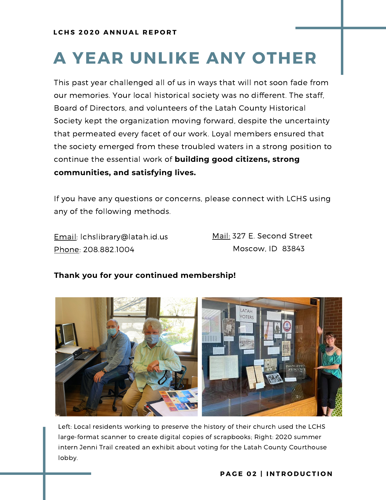

--- Doc 1 ---


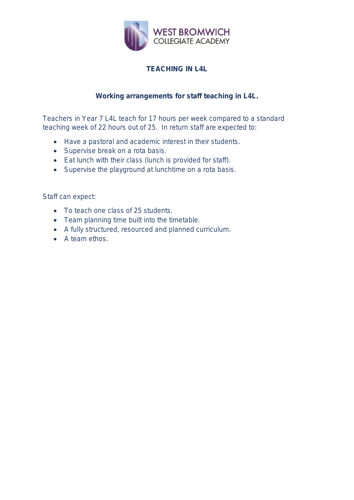

--- Doc 2 ---


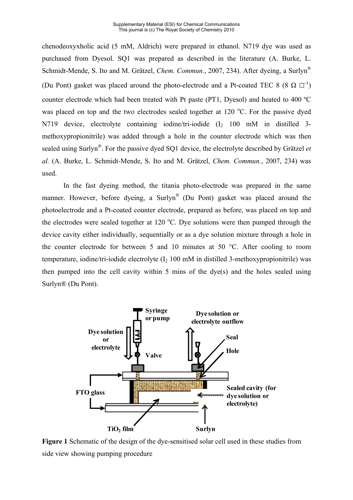

In [3]:
# Preview 3 random document images
from datasets import load_dataset
from itertools import islice
from IPython.display import display

ds = load_dataset("HuggingFaceM4/FineVision", "olmOCR-mix-0225-documents", split="train", streaming=True).shuffle(seed=123)
for i, s in enumerate(islice(ds, 3)):
    print(f"--- Doc {i} ---")
    img = s["images"][0]
    img.thumbnail((500, 500))  # Resize to max 500px
    display(img)

## 🔐 Authentication

### 🔑 AWS Authentication

Before running this notebook, ensure your AWS credentials are configured. You can authenticate using one of these methods:

**Option 1: AWS SSO (recommended for organizations)**
```bash
aws configure sso
aws sso login --profile your-profile-name
```

**Option 2: IAM credentials via environment variables**
```bash
export AWS_ACCESS_KEY_ID=your-access-key
export AWS_SECRET_ACCESS_KEY=your-secret-key
export AWS_DEFAULT_REGION=us-east-1
```

**Option 3: AWS CLI configuration**
```bash
aws configure
```

For more details, see the [AWS CLI Configuration Guide](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-files.html).

> **Note**: When running on SageMaker Studio or EC2 with an IAM role attached, credentials are automatically available via the instance metadata service.

In [ ]:
!pip3 install sagemaker --upgrade --quiet

In [ ]:
!pip install -U "datasets>=4.0.0" "s3fs" "fsspec"

In [ ]:
# 🔑 Authenticate with Hugging Face
# Required for accessing private datasets and pushing results
# Get your token at: https://huggingface.co/settings/tokens
import os
from huggingface_hub import login, get_token

login()

# Store token in env var for SageMaker Jobs
HF_TOKEN = get_token()
os.environ["HF_TOKEN"] = HF_TOKEN
print(f"HF_TOKEN set: {HF_TOKEN[:8]}...")


In [3]:
import os
import json
import shutil
import tempfile
import time
from pathlib import Path

import boto3
import sagemaker
from sagemaker.train.model_trainer import ModelTrainer
from sagemaker.train.configs import SourceCode, Compute, StoppingCondition, OutputDataConfig
from sagemaker.core.helper.session_helper import Session, get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## ⚙️ Configuration

In [ ]:
# Initialize SageMaker session
sagemaker_session = Session()
iam = boto3.client('iam')
role = iam.get_role(RoleName='<YOUR-ROLE-NAME>')['Role']['Arn']
region = sagemaker_session.boto_region_name
account_id = boto3.client("sts").get_caller_identity()["Account"]

print(f"Region: {region}")
print(f"Account: {account_id}")
print(f"Role: {role}")

In [7]:
# Pipeline Configuration
PROJECT_NAME = "deepseek-ocr-sagemaker"
BUCKET_NAME = sagemaker_session.default_bucket()
S3_PREFIX = f"{PROJECT_NAME}"

# S3 output path (single location for all stages - dataset gets updated in place)
S3_OUTPUT_URI = f"s3://{BUCKET_NAME}/{S3_PREFIX}"

# vLLM Container - use SageMaker vLLM DLC
TRAINING_IMAGE = f"763104351884.dkr.ecr.{region}.amazonaws.com/vllm:0.12.0-gpu-py312-cu129-ubuntu22.04-sagemaker-v1.0"  # GPU stages
LIGHTWEIGHT_IMAGE = f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training:2.4.0-cpu-py311-ubuntu22.04-sagemaker"  # CPU-only assemble

# Instance configuration
INSTANCE_TYPE = "ml.g6e.2xlarge"  # GPU instances for extract/describe stages
INSTANCE_TYPE_CPU = "ml.c5.xlarge"  # CPU-only instance for assemble stage (much cheaper)  # Single L40s GPU
# INSTANCE_TYPE = "ml.p4d.24xlarge"  # 8x A100 GPUs for larger scale
VOLUME_SIZE_GB = 100
MAX_RUNTIME_SECONDS = 3 * 60 * 60  # 3 hours

# Source dataset (from HuggingFace)
SOURCE_DATASET = "HuggingFaceM4/FineVision"
SOURCE_CONFIG = "olmOCR-mix-0225-documents"
MAX_SAMPLES = 1024  # Start small for testing

# HuggingFace token for accessing source datasets
HF_TOKEN = os.environ.get("HF_TOKEN", "")

print(f"S3 Bucket: s3://{BUCKET_NAME}/{S3_PREFIX}")
print(f"S3 Output URI: {S3_OUTPUT_URI}")
print(f"Instance: {INSTANCE_TYPE}")
print(f"Source: {SOURCE_DATASET}/{SOURCE_CONFIG} ({MAX_SAMPLES} samples)")

S3 Bucket: s3://sagemaker-us-east-1-754289655784/deepseek-ocr-sagemaker
S3 Output URI: s3://sagemaker-us-east-1-754289655784/deepseek-ocr-sagemaker
Instance: ml.g6e.2xlarge
Source: HuggingFaceM4/FineVision/olmOCR-mix-0225-documents (1024 samples)


## 📦 Bundle Pipeline Code

SageMaker automatically uploads this bundle to S3 and makes it available at `/opt/ml/input/data/code`.

In [8]:
# Paths to pipeline code
CODE_PATHS = [
    Path("entry.sh"),
    Path("sm_job_runner.py"),
    Path("../llm_ocr"),
]

# Create a source directory bundle
source_dir = Path(tempfile.mkdtemp(prefix="sm-ocr-code-"))

for path in CODE_PATHS:
    src = Path.cwd() / path if not path.is_absolute() else path
    if src.is_dir():
        shutil.copytree(src, source_dir / path.name, dirs_exist_ok=True)
    else:
        shutil.copy2(src, source_dir / path.name)

print(f"Source directory: {source_dir}")
print(f"Contents: {list(source_dir.iterdir())}")

Source directory: /tmp/sm-ocr-code-xymxcvqk
Contents: [PosixPath('/tmp/sm-ocr-code-xymxcvqk/llm_ocr'), PosixPath('/tmp/sm-ocr-code-xymxcvqk/sm_job_runner.py'), PosixPath('/tmp/sm-ocr-code-xymxcvqk/entry.sh')]


In [ ]:
# Dependencies are declared in sm_job_runner.py inline metadata (PEP 723)
# entry.sh installs uv and runs: uv run sm_job_runner.py
# This automatically installs all dependencies

## 🔧 Define Base Environment Variables

In [9]:
# Base environment variables for all stages
# All configuration is passed via environment variables (same as HF Jobs)
BASE_ENV = {
    # vLLM configuration
    "MODEL_ID": "deepseek-ai/DeepSeek-OCR",
    "SERVED_MODEL_NAME": "deepseek-ocr",
    "HOST": "0.0.0.0",
    "PORT": "8000",
    "MAX_MODEL_LEN": "8192",
    "GPU_MEMORY_UTILIZATION": "0.90",
    "TENSOR_PARALLEL_SIZE": "1",
    
    # HuggingFace authentication (for source datasets)
    # Note: For production, consider using AWS Secrets Manager instead of env vars
    "HF_TOKEN": os.environ.get("HF_TOKEN", ""),
    "HF_HUB_ENABLE_HF_TRANSFER": "1",
    
    # Prompts
    "DOC_PROMPT": "<image>\n<|grounding|>Convert this document to Markdown.",
    "DOC_MAX_TOKENS": "4096",
    "DOC_TEMPERATURE": "0.1",
    "FIGURE_PROMPT": "<image>\nDescribe this image in detail.",
    "FIGURE_MAX_TOKENS": "512",
    "FIGURE_TEMPERATURE": "0.6",
}

## 🛠️ Helper Functions

In [10]:
# Import IO and rendering utilities from llm_ocr
import sys; sys.path.insert(0, "..")
from llm_ocr.sm_io import load_dataset_from_s3
from llm_ocr.document import render_sample_markdown, display_markdown, display_samples


def launch_stage(stage: str, env: dict = None, use_gpu: bool = True):
    """Launch a pipeline stage as a SageMaker Training Job.
    
    Args:
        stage: Pipeline stage (extract, describe, assemble)
        env: Stage-specific environment variables (optional)
        use_gpu: Whether to use GPU instance and image (default True)
        
    Returns:
        Tuple of (ModelTrainer, job_name)
    """
    import uuid
    
    # Generate unique base job name
    unique_id = uuid.uuid4().hex[:8]
    base_name = f"{PROJECT_NAME}-{stage}-{unique_id}"
    
    # Merge base env with stage-specific env
    full_env = {**BASE_ENV, "PIPELINE_STAGE": stage}
    if env:
        full_env.update(env)
    
    # Select image and instance based on GPU usage
    if use_gpu:
        image_uri = TRAINING_IMAGE
        instance_type = INSTANCE_TYPE
    else:
        # Lightweight config for CPU-only stages (assemble)
        image_uri = LIGHTWEIGHT_IMAGE
        instance_type = INSTANCE_TYPE_CPU
    
    # Create trainer
    trainer = ModelTrainer(
        sagemaker_session=sagemaker_session,
        role=role,
        training_mode="SAGEMAKER_TRAINING_JOB",
        source_code=SourceCode(
            source_dir=str(source_dir),
            entry_script="entry.sh",
        ),
        compute=Compute(
            instance_type=instance_type,
            instance_count=1,
            volume_size_in_gb=VOLUME_SIZE_GB,
        ),
        stopping_condition=StoppingCondition(
            max_runtime_in_seconds=MAX_RUNTIME_SECONDS,
        ),
        output_data_config=OutputDataConfig(
            s3_output_path=f"s3://{BUCKET_NAME}/{S3_PREFIX}/output/",
        ),
        base_job_name=base_name,
        environment=full_env,
        training_image=image_uri,
    )
    
    print(f"Launching {stage} stage...")
    trainer.train(wait=False)
    
    # Find the actual job name using list_training_jobs API
    sm_client = sagemaker_session.sagemaker_client
    time.sleep(2)  # Brief wait for job to register
    response = sm_client.list_training_jobs(
        NameContains=base_name,
        SortBy='CreationTime',
        SortOrder='Descending',
        MaxResults=1
    )
    
    if response['TrainingJobSummaries']:
        actual_job_name = response['TrainingJobSummaries'][0]['TrainingJobName']
    else:
        actual_job_name = base_name  # Fallback
    
    print(f"Job started: {actual_job_name}")
    return trainer, actual_job_name


def wait_for_job(job_name: str, poll_interval: int = 30, timeout: int = 10800):
    """Wait for a SageMaker Training Job to complete.
    
    Args:
        job_name: The exact job name
        poll_interval: Seconds between status checks
        timeout: Maximum seconds to wait
    """
    sm_client = sagemaker_session.sagemaker_client
    start_time = time.time()
    
    print(f"Waiting for job {job_name}...")
    
    while time.time() - start_time < timeout:
        response = sm_client.describe_training_job(TrainingJobName=job_name)
        status = response['TrainingJobStatus']
        
        elapsed = time.time() - start_time
        mins, secs = divmod(int(elapsed), 60)
        
        if status == 'Completed':
            print(f"  {job_name}: Completed ✓ ({mins:02d}:{secs:02d})")
            return response
        elif status == 'Failed':
            print(f"  {job_name}: Failed ✗")
            print(f"  Reason: {response.get('FailureReason', 'Unknown')}")
            return response
        elif status == 'Stopped':
            print(f"  {job_name}: Stopped")
            return response
        else:
            print(f"  {job_name}: {status}... ({mins:02d}:{secs:02d})")
        
        time.sleep(poll_interval)
    
    raise TimeoutError(f"Job {job_name} did not complete within {timeout}s")


## 🔍 Stage 1: Extract

Run OCR on the source dataset to extract markdown and figures.
Output is saved to S3 (not HF Hub).

![Extract Stage](./assets/extract-aws.png)


### How to set up batch size for efficient processing

Since we're running **batch inference** (not serving live users), we can aggressively maximize GPU utilization without worrying about latency SLAs. The goal is to keep the GPU fully saturated by maintaining enough concurrent requests in flight.

**Understanding vLLM's KV cache capacity**

vLLM allocates GPU memory for its KV cache, which determines how many concurrent requests can be processed. When vLLM starts, it calculates and logs the KV cache capacity for your specific GPU:

```
INFO [kv_cache_utils.py] GPU KV cache size: 567,488 tokens
INFO [kv_cache_utils.py] Maximum concurrency for 8,192 tokens per request: 69.27x
```

Check your job logs to find these values for your hardware. The maximum concurrency depends on:

```
max_concurrency = KV_cache_tokens / tokens_per_request
```

For the **G6E instance (L40S GPU, 48GB)** with a sizing length of **8,192 total tokens** (prompt + generated):

| GPU | KV Cache Tokens | Hard Cap | Safe Target (70-85%) |
|-----|-----------------|----------|----------------------|
| **L40S** (48GB) | ~567,488 | 69 | **50-60** |

**Setting safe concurrency**

The `EXTRACT_BATCH_SIZE` parameter controls concurrent requests sent to vLLM. To set it safely:

1. **Estimate total tokens per request**: `L_total = prompt_tokens + generated_tokens`. For OCR, generated markdown can be substantial - use your **p95** (not average) to avoid preemption.
2. **Apply 70-85% headroom**: This accounts for variance in document lengths and prevents KV cache pressure.
3. **If most docs are well below 8,192 tokens**, you can push higher concurrency.

**Our dataset: 1 page = 1 request**

In this pipeline, each request processes a **single PDF page**, which typically produces far fewer tokens than the 8,192 sizing length. This allows us to push concurrency well beyond the conservative estimates above. In practice, **128 concurrent requests worked safely on G6E (L40S)** - nearly 2x the theoretical hard cap - because actual token usage per page is much lower.

In [ ]:
# Stage 1: Extract
# Output dataset will be saved to S3
stage1_env = {
    # Source dataset (from HuggingFace)
    "DATASET_NAME": SOURCE_DATASET,
    "DATASET_CONFIG": SOURCE_CONFIG,
    "DATASET_SPLIT": "train",
    "MAX_SAMPLES": str(MAX_SAMPLES),
    
    # Local output directory
    "OUTPUT_DIR": "./outputs",
    
    # Batch settings
    "EXTRACT_BATCH_SIZE": "128",
    
    # S3 output (single location for all stages)
    "S3_OUTPUT_URI": S3_OUTPUT_URI,
}

stage1_trainer, stage1_job_name = launch_stage("extract", stage1_env)

[01/14/26 23:07:06] INFO     OutputDataConfig compression type not provided. Using default:         ]8;id=829200;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/defaults.py\defaults.py]8;;\:]8;id=300400;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/defaults.py#162\162]8;;\
                             GZIP                                                                                  

                    INFO     Training image URI:                                               ]8;id=333069;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py\model_trainer.py]8;;\:]8;id=537518;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py#537\537]8;;\
                             763104351884.dkr.ecr.us-east-1.amazonaws.com/vllm:0.12.0-gpu-py31                     
                             2-cu129-ubuntu22.04-sagemaker-v1.0                                                    

Launching extract stage...


                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=610334;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=606134;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/telemetry/telemetry_logging.py#92\92]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[01/14/26 23:07:07] INFO     Creating training_job resource.                                     ]8;id=393946;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=784468;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/resources.py#35539\35539]8;;\

[01/14/26 23:07:08] WARNING  Not displaing the training container logs as 'wait' is set to     ]8;id=847469;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py\model_trainer.py]8;;\:]8;id=135109;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py#762\762]8;;\
                             False.                                                                                

Job started: deepseek-ocr-sagemaker-extract-1a54e6b4-20260114230706


In [ ]:
# Wait for Stage 1 to complete
# Estimated time: ~15-20 min for 1024 samples on ml.g6e.2xlarge (scales linearly)
stage1_result = wait_for_job(stage1_job_name)
print(f"Extract stage completed: {stage1_result['TrainingJobStatus']}")


[01/15/26 11:22:30] INFO     Loading dataset from                                                      ]8;id=478078;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py\sm_io.py]8;;\:]8;id=920353;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py#163\163]8;;\
                             s3://sagemaker-us-east-1-754289655784/deepseek-ocr-sagemaker/dataset                  

[01/15/26 11:22:35] INFO     Downloaded 5 files to /tmp/s3_dataset_rgiq48fa                            ]8;id=331822;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py\sm_io.py]8;;\:]8;id=379235;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py#184\184]8;;\

Dataset: 1023 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


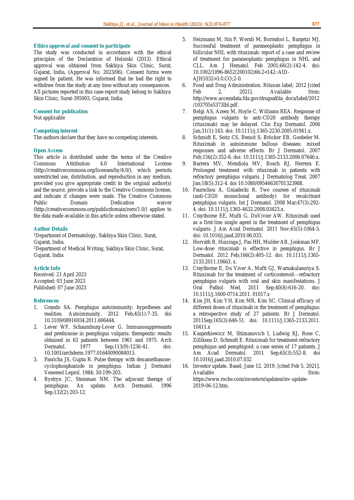


Markdown preview (4756 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

=== Sample 1: sample_00001 ===
Source image:


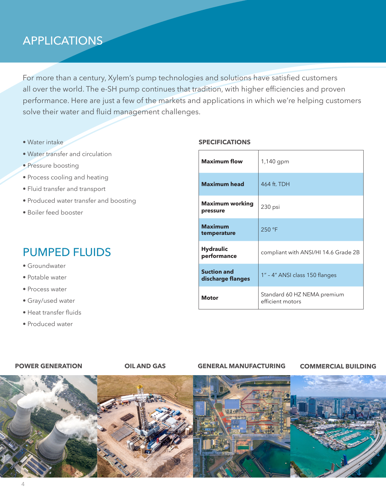


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Extracted figures: 1


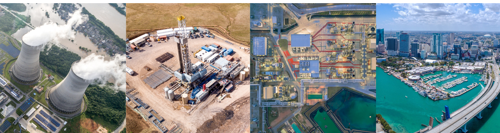

In [11]:
# Load and display samples after Extract
ds_extract = load_dataset_from_s3(f"{S3_OUTPUT_URI}/dataset")
display_samples(ds_extract, num_samples=2)

## 🏷️ Stage 2: Describe

Generate captions for extracted figures.
Input is read from S3 (output of Stage 1), output is saved to S3.

![Describe Stage](./assets/describe-aws.png)


In [12]:
# Stage 2: Describe
# Updates dataset in place (same location as extract)
stage2_env = {
    # Local output directory
    "OUTPUT_DIR": "./outputs",
    
    # Batch settings
    "DESCRIBE_BATCH_SIZE": "128",
    
    # S3 input and output (same location - updates in place)
    "S3_INPUT_URI": f"{S3_OUTPUT_URI}/dataset",
    "S3_OUTPUT_URI": S3_OUTPUT_URI,
}

stage2_trainer, stage2_job_name = launch_stage("describe", stage2_env)

[01/15/26 11:22:43] INFO     OutputDataConfig compression type not provided. Using default:         ]8;id=536413;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/defaults.py\defaults.py]8;;\:]8;id=161591;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/defaults.py#162\162]8;;\
                             GZIP                                                                                  

                    INFO     Training image URI:                                               ]8;id=559296;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py\model_trainer.py]8;;\:]8;id=975326;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py#537\537]8;;\
                             763104351884.dkr.ecr.us-east-1.amazonaws.com/vllm:0.12.0-gpu-py31                     
                             2-cu129-ubuntu22.04-sagemaker-v1.0                                                    

Launching describe stage...


                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=815445;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=323031;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/telemetry/telemetry_logging.py#92\92]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[01/15/26 11:22:44] INFO     Creating training_job resource.                                     ]8;id=538601;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=227204;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/resources.py#35539\35539]8;;\

                    WARNING  No region provided. Using default region.                                 ]8;id=267939;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/utils/utils.py\utils.py]8;;\:]8;id=369359;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/utils/utils.py#340\340]8;;\

                    INFO     Runs on sagemaker prod, region:us-east-1                                  ]8;id=170811;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/utils/utils.py\utils.py]8;;\:]8;id=163101;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/utils/utils.py#354\354]8;;\

[01/15/26 11:22:45] WARNING  Not displaing the training container logs as 'wait' is set to     ]8;id=715031;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py\model_trainer.py]8;;\:]8;id=825082;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py#762\762]8;;\
                             False.                                                                                

Job started: deepseek-ocr-sagemaker-describe-e7a0a2b5-20260115112243


In [14]:
# Wait for Stage 2 to complete
# Estimated time: ~8-10 min for 1024 samples on ml.g6e.2xlarge
stage2_result = wait_for_job(stage2_job_name)
print(f"Describe stage completed: {stage2_result['TrainingJobStatus']}")


Waiting for job deepseek-ocr-sagemaker-describe-e7a0a2b5-20260115112243...
  deepseek-ocr-sagemaker-describe-e7a0a2b5-20260115112243: Completed ✓ (00:00)
Describe stage completed: Completed


[01/15/26 11:40:30] INFO     Loading dataset from                                                      ]8;id=535649;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py\sm_io.py]8;;\:]8;id=548882;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py#163\163]8;;\
                             s3://sagemaker-us-east-1-754289655784/deepseek-ocr-sagemaker/dataset                  

[01/15/26 11:40:33] INFO     Downloaded 5 files to /tmp/s3_dataset_f3k1tm9k                            ]8;id=329650;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py\sm_io.py]8;;\:]8;id=399506;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py#184\184]8;;\

Dataset: 1023 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


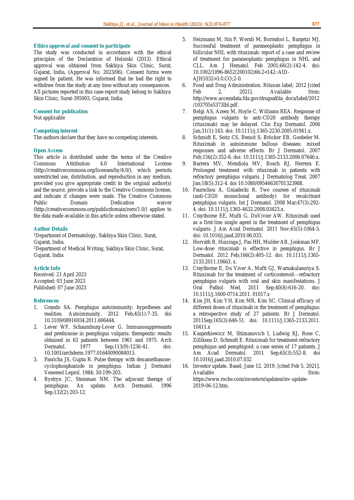


Markdown preview (4756 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

=== Sample 1: sample_00001 ===
Source image:


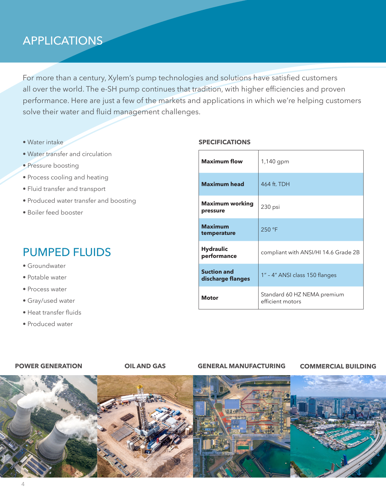


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Extracted figures: 1


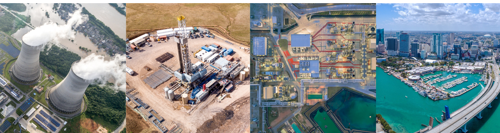

  📝 Description: The figure provided showcases three different types of industrial sites, each representing a distinct type of industrial activity. These sites are part of the Industrial Dataset used in the paper "Uns...



In [15]:
# Load and display samples after Describe
ds_describe = load_dataset_from_s3(f"{S3_OUTPUT_URI}/dataset")
display_samples(ds_describe, num_samples=2)

## 🧩 Stage 3: Assemble

Enrich markdown with figure captions to create the final dataset. This stage runs **CPU-only** with a lightweight image and smaller instance type - no vLLM or GPU needed.

> 💡 Uses `LIGHTWEIGHT_IMAGE` + `INSTANCE_TYPE_CPU` instead of the full vLLM setup, significantly reducing costs.

![Assemble Stage](./assets/assemble-aws.png)


In [16]:
# Stage 3: Assemble
# Updates dataset in place + saves final markdown files
stage3_env = {
    # Local output directory
    "OUTPUT_DIR": "./outputs",
    
    # S3 input and output (same location - updates in place)
    "S3_INPUT_URI": f"{S3_OUTPUT_URI}/dataset",
    "S3_OUTPUT_URI": S3_OUTPUT_URI,
    
    # Assemble stage doesn't need GPU
    "SKIP_SERVER_LAUNCH": "true",
}

stage3_trainer, stage3_job_name = launch_stage("assemble", stage3_env, use_gpu=False)  # CPU-only

[01/15/26 11:40:38] INFO     OutputDataConfig compression type not provided. Using default:         ]8;id=277978;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/defaults.py\defaults.py]8;;\:]8;id=318623;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/defaults.py#162\162]8;;\
                             GZIP                                                                                  

                    INFO     Training image URI:                                               ]8;id=193167;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py\model_trainer.py]8;;\:]8;id=373931;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py#537\537]8;;\
                             763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:2.4                     
                             .0-cpu-py311-ubuntu22.04-sagemaker                                                    

Launching assemble stage...


                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=895737;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=955093;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/telemetry/telemetry_logging.py#92\92]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[01/15/26 11:40:39] INFO     Creating training_job resource.                                     ]8;id=868399;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=525028;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/core/resources.py#35539\35539]8;;\

[01/15/26 11:40:40] WARNING  Not displaing the training container logs as 'wait' is set to     ]8;id=442808;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py\model_trainer.py]8;;\:]8;id=503036;file:///opt/pytorch/lib/python3.12/site-packages/sagemaker/train/model_trainer.py#762\762]8;;\
                             False.                                                                                

Job started: deepseek-ocr-sagemaker-assemble-107f1257-20260115114038


In [17]:
# Wait for Stage 3 to complete
# Estimated time: ~3-5 min (CPU-only, just text processing)
stage3_result = wait_for_job(stage3_job_name)
print(f"Assemble stage completed: {stage3_result['TrainingJobStatus']}")


Waiting for job deepseek-ocr-sagemaker-assemble-107f1257-20260115114038...
  deepseek-ocr-sagemaker-assemble-107f1257-20260115114038: InProgress... (00:00)
  deepseek-ocr-sagemaker-assemble-107f1257-20260115114038: InProgress... (00:30)
  deepseek-ocr-sagemaker-assemble-107f1257-20260115114038: InProgress... (01:00)
  deepseek-ocr-sagemaker-assemble-107f1257-20260115114038: InProgress... (01:30)
  deepseek-ocr-sagemaker-assemble-107f1257-20260115114038: InProgress... (02:00)
  deepseek-ocr-sagemaker-assemble-107f1257-20260115114038: InProgress... (02:30)
  deepseek-ocr-sagemaker-assemble-107f1257-20260115114038: Completed ✓ (03:00)
Assemble stage completed: Completed


[01/15/26 11:45:19] INFO     Loading dataset from                                                      ]8;id=55085;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py\sm_io.py]8;;\:]8;id=431954;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py#163\163]8;;\
                             s3://sagemaker-us-east-1-754289655784/deepseek-ocr-sagemaker/dataset                  

[01/15/26 11:45:22] INFO     Downloaded 5 files to /tmp/s3_dataset_louoimcz                            ]8;id=672097;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py\sm_io.py]8;;\:]8;id=714433;file:///home/ec2-user/aws-llm-lab/batch-ocr-inference/sagemaker/../llm_ocr/sm_io.py#184\184]8;;\

Dataset: 1023 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


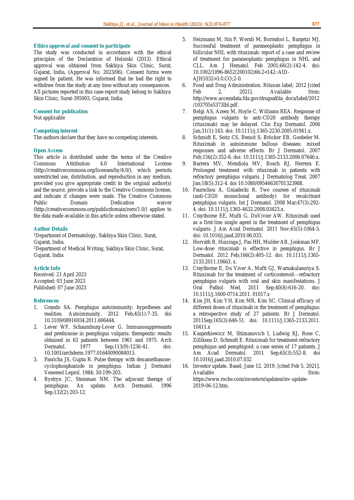


Markdown preview (4756 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

Final markdown preview (4756 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in thi

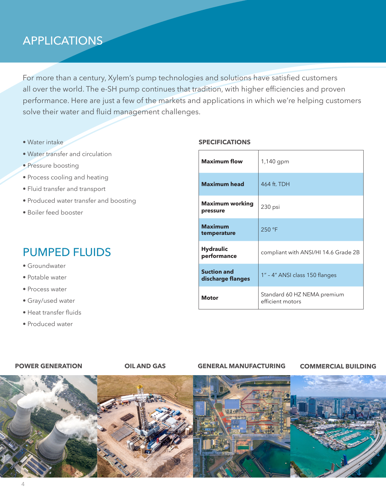


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Final markdown preview (3472 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Pr

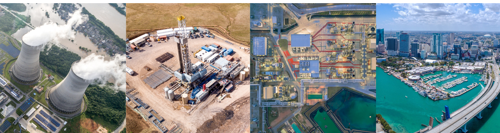

  📝 Description: The figure provided showcases three different types of industrial sites, each representing a distinct type of industrial activity. These sites are part of the Industrial Dataset used in the paper "Uns...



In [18]:
# Load and display final samples after Assemble
ds_final = load_dataset_from_s3(f"{S3_OUTPUT_URI}/dataset")
display_samples(ds_final, num_samples=2)

# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water transfer and boosting- Boiler feed booster  

## PUMPED FLUIDS  

- Groundwater- Potable water- Process water- Gray/used water- Heat transfer fluids- Produced water  

## SPECIFICATIONS  

<table><tr><td>Maximum flow</td><td>1,140 gpm</td></tr><tr><td>Maximum head</td><td>464 ft. TDH</td></tr><tr><td>Maximum working pressure</td><td>230 psi</td></tr><tr><td>Maximum temperature</td><td>250 °F</td></tr><tr><td>Hydraulic performance</td><td>compliant with ANSI/HI 14.6 Grade 2B</td></tr><tr><td>Suction and discharge flanges</td><td>1&quot; - 4&quot; ANSI class 150 flanges</td></tr><tr><td>Motor</td><td>Standard 60 HZ NEMA premium efficient motors</td></tr></table>  

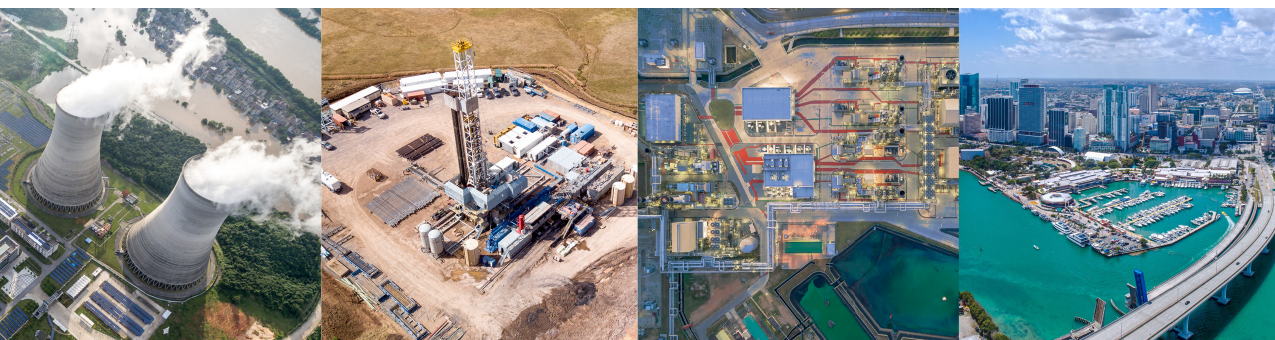

*Figure sample_00001_fig01: The figure provided showcases three different types of industrial sites, each representing a distinct type of industrial activity. These sites are part of the Industrial Dataset used in the paper "Unsupervised Industrial Image Segmentation Based on Fully Convolutional Networks." The images are labeled as "factory," "processing plant," and "port," respectively.

1. **Factory (Left Image)**:
   - The factory in the left image appears to be a large, open industrial complex with multiple buildings and structures.
   - There are two prominent cooling towers emitting white smoke, indicating the presence of heavy machinery or processes that generate heat.
   - Surrounding the factory are various industrial facilities, roads, and possibly other infrastructure elements.
   - The overall layout suggests a dense and complex industrial environment.

2. **Processing Plant (Middle Image)**:
   - The middle image depicts a more complex industrial setting, likely a processing plant.
   - Multiple buildings, storage tanks, and conveyor systems are visible, indicating a facility involved in manufacturing or processing operations.
   - There is a large, open area with several smaller structures, possibly offices or control rooms.
   - The presence of heavy machinery and the layout suggest an extensive industrial operation.

3. **Port (Right Image)**:
   - The rightmost image shows a port, characterized by its extensive infrastructure and waterways.
   - Multiple docks and piers are visible, with numerous cargo ships and vessels docked.
   - The port is surrounded by a network of roads and railways, indicating its role in facilitating the transportation of goods.
   - The presence of water bodies and the layout of the port facilities highlight its importance in industrial and logistical operations.

These images collectively represent different industrial environments, each with its unique characteristics and infrastructure. The dataset aims to provide a comprehensive understanding of various industrial settings, which can be used for tasks such as unsupervised industrial image segmentation.*


In [19]:
# Display rendered markdown with images for sample 1
# This properly renders figure: URIs using images from extracted_figures column
display_markdown(ds_final[1])

## 💰 Cost Analysis (Extract stage only)

| Metric | Value |
|--------|-------|
| 🖥️ **Hardware** | ml.g6e.2xlarge (L40S, 48GB) |
| ⚡ **Throughput** | ~83 pages/min |
| 🔄 **Concurrency** | 128 parallel requests (saturates GPU batch) |
| 💵 **Hourly rate** | ~$2.80/hour |

| Scale | ⏱️ Time | 💲 Cost |
|-------|------|------|
| 1,000 pages | ~12 min | ~$0.56 |
| 10,000 pages | ~2 hours | ~$5.60 |
| 100,000 pages | ~20 hours | ~$56 |

> 📄 **Note**: 1 page = 1 PDF page in these benchmarks. Pricing based on [SageMaker on-demand pricing](https://aws.amazon.com/sagemaker/pricing/).

> 💡 **Cost optimization**: These costs can be further optimized by evaluating the best instance type and hardware utilization based on your dataset characteristics (average page complexity, token lengths, batch sizes). Consider testing different instance types (e.g., ml.g5, ml.p4d) to find the optimal price/performance ratio for your workload.

## ✅ Pipeline Complete

The OCR pipeline has finished. Your dataset is available in S3:

In [ ]:
print(f"\n" + "="*60)
print("Pipeline Complete!")
print("="*60)
print(f"\nS3 Output Location: {S3_OUTPUT_URI}")
print(f"  - Dataset: {S3_OUTPUT_URI}/dataset/")
print(f"  - Files: {S3_OUTPUT_URI}/outputs/")
print(f"\nS3 Job Output: s3://{BUCKET_NAME}/{S3_PREFIX}/output/")
print("\nJob Summary:")
for i, (name, result) in enumerate([
    ("Extract", stage1_result),
    ("Describe", stage2_result),
    ("Assemble", stage3_result),
], 1):
    status = result["TrainingJobStatus"]
    print(f"  {i}. {name}: {status}")